In [5]:
import os
import shutil
import random
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import albumentations as A
from tqdm import tqdm

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

from tf_explain.core.grad_cam import GradCAM

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.regularizers import l2

# **Import Data**

## Check number of images in each class

In [6]:
# Define the path to the original dataset
original_dir = "/kaggle/input/cervical-cancer-largest-dataset-sipakmed"

# Define class folder names
classes = ["im_Superficial-Intermediate", "im_Parabasal", "im_Koilocytotic", "im_Dyskeratotic", "im_Metaplastic"]

# Dictionary to store image counts
image_counts = {}

for cls in classes:
    class_main_path = os.path.join(original_dir, cls, cls, "CROPPED")  # Navigate to correct subfolder

    # Get all image files (.bmp format)
    img_files = [f for f in os.listdir(class_main_path) if f.lower().endswith('.bmp')]
    image_counts[cls] = len(img_files)

# Display the results
print("Image Counts in Each Class:")
for cls, count in image_counts.items():
    print(f"{cls}: {count} images")


Image Counts in Each Class:
im_Superficial-Intermediate: 831 images
im_Parabasal: 787 images
im_Koilocytotic: 825 images
im_Dyskeratotic: 813 images
im_Metaplastic: 793 images


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


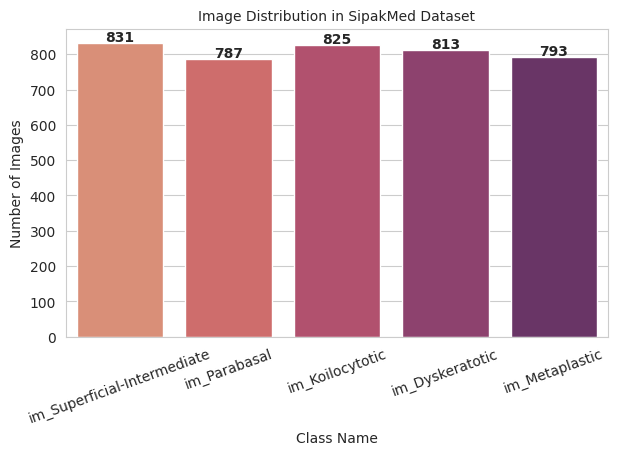

In [7]:
image_counts_num = []
for cls, count in image_counts.items():
    image_counts_num.append(count)

sns.set_style("whitegrid")

# Plot histogram using Seaborn
plt.figure(figsize=(7, 4))
sns.barplot(x=classes, y=image_counts_num, palette="flare")

# Add labels and title
plt.xlabel("Class Name", fontsize=10)
plt.ylabel("Number of Images", fontsize=10)
plt.title("Image Distribution in SipakMed Dataset", fontsize=10)

# Rotate x-axis labels
plt.xticks(rotation=20)

# Show counts on top of bars
for i, count in enumerate(image_counts_num):
    plt.text(i, count + 5, str(count), ha='center', fontsize=10, fontweight='bold')

# Show plot
plt.show()

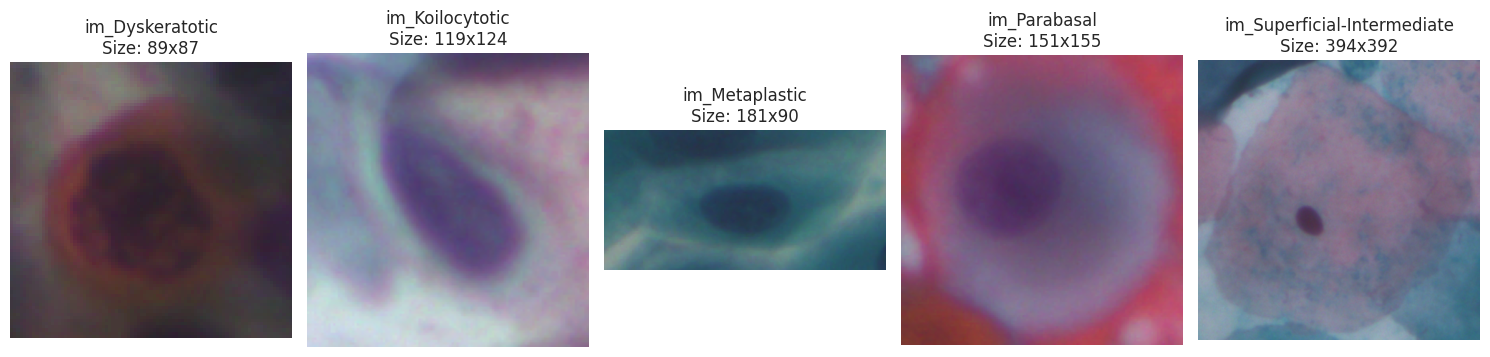

In [8]:
# Get class names
classes = sorted([cls for cls in os.listdir(original_dir)])

# Create a figure for visualization
fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))

for i, cls in enumerate(classes):
    class_path = os.path.join(original_dir, cls, cls, "CROPPED")
    img_files = [f for f in os.listdir(class_path) if f.lower().endswith('.bmp')]

    # Select a random image
    img_file = random.choice(img_files)
    img_path = os.path.join(class_path, img_file)

    # Read image using OpenCV
    img = cv2.imread(img_path)

    # Get image dimensions
    height, width, _ = img.shape
    img_size = f"{width}x{height}"

    # Convert BGR to RGB for Matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image
    axes[i].imshow(img)
    axes[i].set_title(f"{cls}\nSize: {img_size}")  # Show class + size
    axes[i].axis("off")

plt.tight_layout()
plt.show()

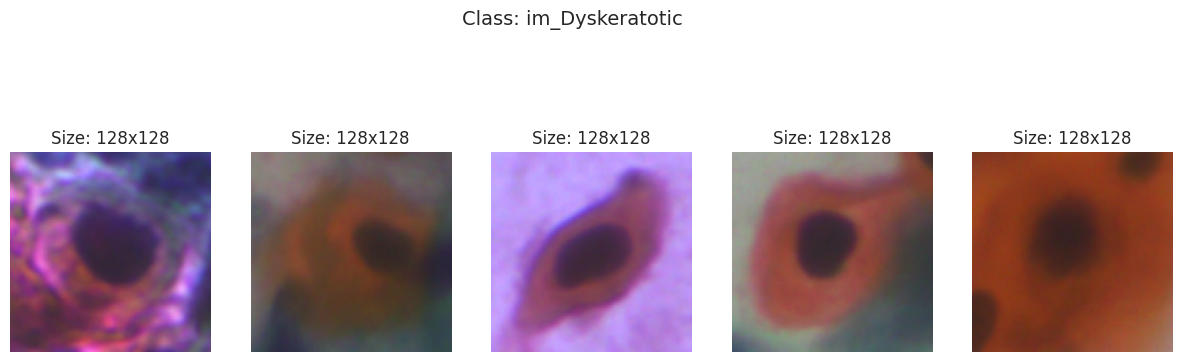

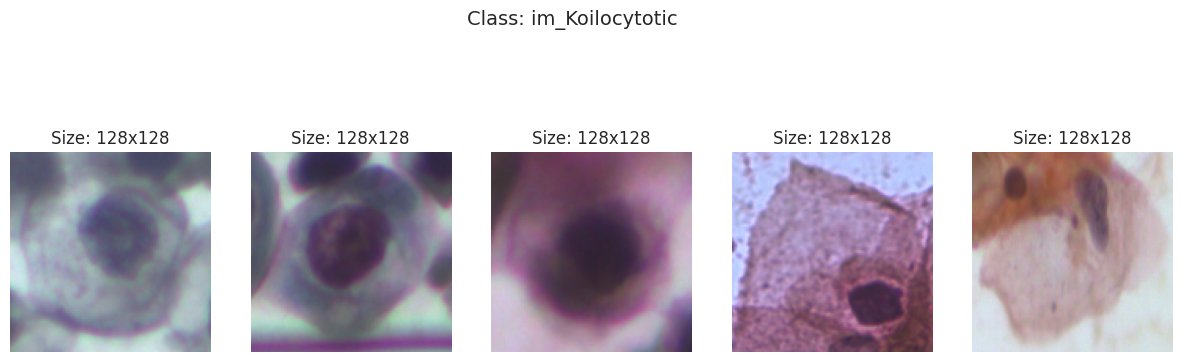

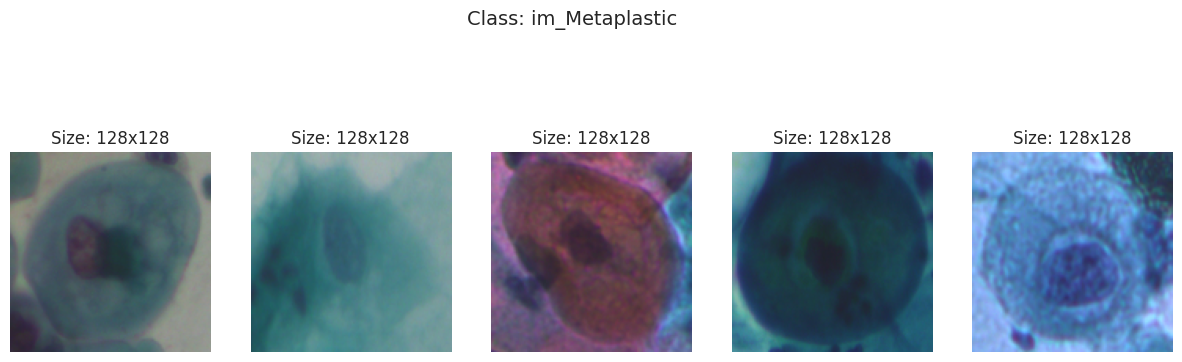

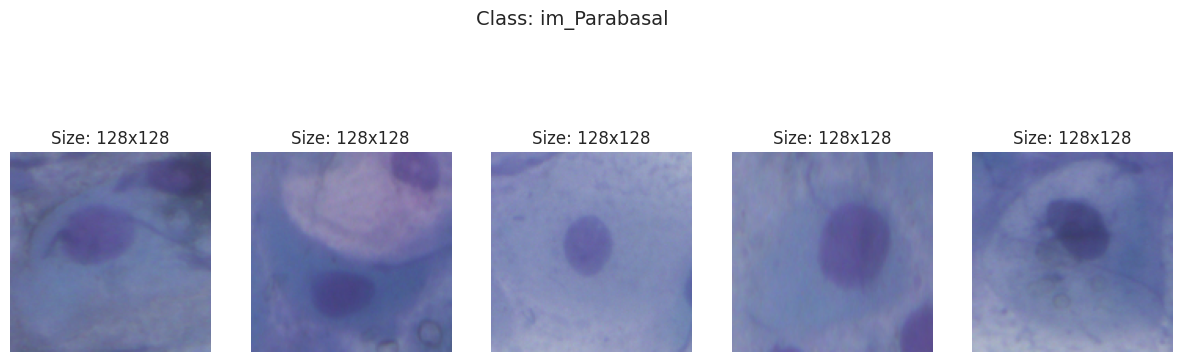

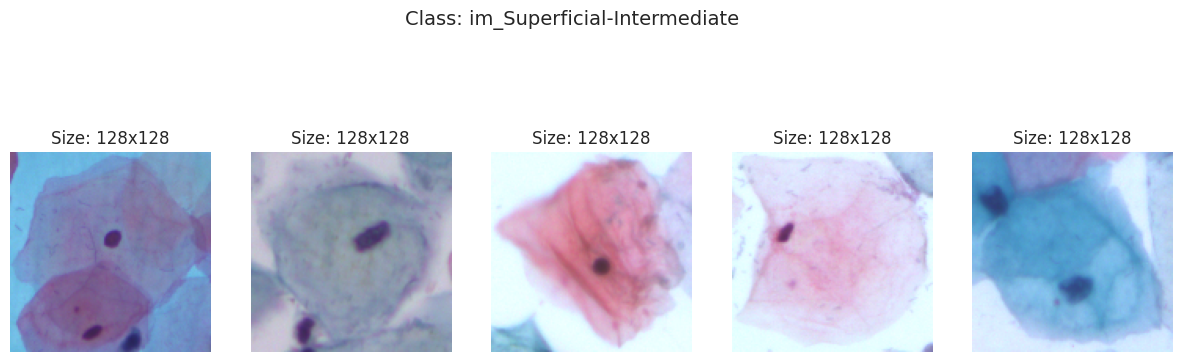

In [9]:
for cls in classes:
    class_path = os.path.join(original_dir, cls, cls, "CROPPED")

    # Get all image files (.bmp format)
    img_files = [f for f in os.listdir(class_path) if f.lower().endswith('.bmp')]

    # Randomly select 5 images
    selected_files = random.sample(img_files, min(5, len(img_files)))

    # Plot images
    fig, axes = plt.subplots(1, len(selected_files), figsize=(15, 5))
    fig.suptitle(f"Class: {cls}", fontsize=14)

    for i, img_file in enumerate(selected_files):
        img_path = os.path.join(class_path, img_file)

        # Read and convert image to RGB
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))

        # Get image dimensions
        height, width, _ = img.shape
        img_size = f"{width}x{height}"

        # Display image
        axes[i].imshow(img)
        axes[i].set_title(f"Size: {img_size}")  # Show class + size
        axes[i].axis("off")

    plt.show()

# **Preprocessing**

## Resize

In [10]:
# Define dataset path
original_dir = "/kaggle/input/cervical-cancer-largest-dataset-sipakmed"
output_dir = "/kaggle/working/sipakmed_resized"

# Create output directory
os.makedirs(output_dir, exist_ok=True)

for cls in os.listdir(original_dir):
    class_path = os.path.join(original_dir, cls, cls, "CROPPED")
    output_class_path = os.path.join(output_dir, cls)
    
    if not os.path.isdir(class_path):
        continue  #Skip non-folder items

    os.makedirs(output_class_path, exist_ok=True)  # Create output subfolder

    for img_file in os.listdir(class_path):
        if img_file.lower().endswith('.bmp'):  # Only process BMP images
            img_path = os.path.join(class_path, img_file)
            output_img_path = os.path.join(output_class_path, img_file)

            # Read and resize image
            img = cv2.imread(img_path)

            resized_img = cv2.resize(img, (128, 128))  # Resize image

            # Save the resized image
            cv2.imwrite(output_img_path, resized_img)

print(f"All images resized to 128x128 and saved in '{output_dir}'")

All images resized to 128x128 and saved in '/kaggle/working/sipakmed_resized'


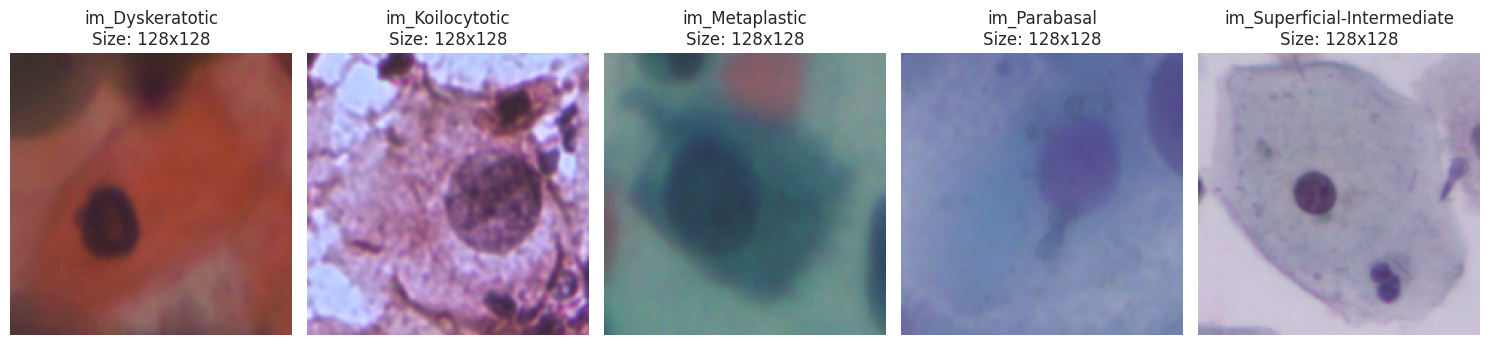

In [11]:
# Define the path to the resized dataset
resized_dataset_dir = "/kaggle/working/sipakmed_resized"

# Get class names
classes = sorted([cls for cls in os.listdir(resized_dataset_dir) if os.path.isdir(os.path.join(resized_dataset_dir, cls))])

# Create a figure for visualization
fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))

for i, cls in enumerate(classes):
    class_path = os.path.join(resized_dataset_dir, cls)
    img_files = [f for f in os.listdir(class_path) if f.lower().endswith('.bmp')]

    # Select a random image
    img_file = random.choice(img_files)
    img_path = os.path.join(class_path, img_file)

    # Read image using OpenCV
    img = cv2.imread(img_path)
            
    # Get image dimensions
    height, width, _ = img.shape
    img_size = f"{width}x{height}"

    # Convert BGR to RGB for Matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image
    axes[i].imshow(img)
    axes[i].set_title(f"{cls}\nSize: {img_size}")  # Show class + size
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [12]:
# Define the path to the resized dataset
resized_dataset_dir = "/kaggle/working/sipakmed_resized"

# Define class folder names
classes = ["im_Superficial-Intermediate", "im_Parabasal", "im_Koilocytotic", "im_Dyskeratotic", "im_Metaplastic"]

# Dictionary to store image counts
image_counts = {}

for cls in classes:
    class_main_path = os.path.join(resized_dataset_dir, cls)  # Navigate to correct subfolder

    # Get all image files (.bmp format)
    img_files = [f for f in os.listdir(class_main_path) if f.lower().endswith('.bmp')]
    image_counts[cls] = len(img_files)

# Display the results
print("Image Counts in Each Class:")
for cls, count in image_counts.items():
    print(f"{cls}: {count} images")

Image Counts in Each Class:
im_Superficial-Intermediate: 831 images
im_Parabasal: 787 images
im_Koilocytotic: 825 images
im_Dyskeratotic: 813 images
im_Metaplastic: 793 images


## **Train test split**

In [13]:
# Define dataset directory
data_dir = "/kaggle/working/sipakmed_resized"
output_dir = "/kaggle/working/sipakmed_split"

# Define train and test directories
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")

# Ensure output directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get class names (subfolders in data_dir)
class_names = sorted(os.listdir(data_dir))

# Iterate over each class
for cls in class_names:
    class_main_path = os.path.join(data_dir, cls)  # Path to class folder
    
    # Get all image file paths in the class
    image_files = [f for f in os.listdir(class_main_path) if f.lower().endswith(('.bmp'))]
    
    # Shuffle images randomly
    random.shuffle(image_files)

    # Select 100 images for test
    test_images = image_files[:100]
    train_images = image_files[100:]  # Remaining images for training

    # Create class subdirectories in train & test folders
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    # Move test images
    for img in test_images:
        src = os.path.join(class_main_path, img)
        dst = os.path.join(test_dir, cls, img)
        shutil.move(src, dst)

    # Move train images
    for img in train_images:
        src = os.path.join(class_main_path, img)
        dst = os.path.join(train_dir, cls, img)
        shutil.move(src, dst)

print("Dataset split into train and test successfully!")

Dataset split into train and test successfully!


## Offline Augmentation

In [14]:
# Define dataset paths
input_dir = "/kaggle/working/sipakmed_split/train"
output_dir = "/kaggle/working/sipakmed_augmented"

# Create output directory
os.makedirs(output_dir, exist_ok=True)

# Define augmentation pipeline
augment = A.Compose([
    A.Perspective(scale=(0.05, 0.1), p=0.5),  # Perspective transformation with 50% probability
    A.Rotate(limit=10, p=1.0),  # Rotation with 100% probability (-10° to +10°)
    A.HorizontalFlip(p=0.5),  # Horizontal flip with 50% probability
    A.VerticalFlip(p=0.5),  # Vertical flip with 50% probability
])

# Augment images in each class
for cls in os.listdir(input_dir):
    class_path = os.path.join(input_dir, cls)
    output_class_path = os.path.join(output_dir, cls)

    if not os.path.isdir(class_path):
        continue  # Skip non-folder items

    os.makedirs(output_class_path, exist_ok=True)  # Create output subfolder

    img_files = [f for f in os.listdir(class_path) if f.lower().endswith('.bmp')]

    for img_file in tqdm(img_files, desc=f"Processing {cls}"):
        img_path = os.path.join(class_path, img_file)

        # Read image using OpenCV
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Couldn't read {img_path}")
            continue

        # Convert image to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Apply augmentation
        augmented = augment(image=img)['image']

        # Convert back to BGR and save
        augmented_bgr = cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR)
        augmented_filename = f"aug_{img_file}"
        cv2.imwrite(os.path.join(output_class_path, augmented_filename), augmented_bgr)

print(f"Augmented images saved in '{output_dir}'")


Processing im_Parabasal: 100%|██████████| 687/687 [00:00<00:00, 1275.86it/s]

Augmented images saved in '/kaggle/working/sipakmed_augmented'


In [15]:
# Define the path to the original dataset
output_dir = "/kaggle/working/sipakmed_augmented"

# Define class folder names
classes = ["im_Superficial-Intermediate", "im_Parabasal", "im_Koilocytotic", "im_Dyskeratotic", "im_Metaplastic"]

# Dictionary to store image counts
image_counts = {}

for cls in classes:
    class_main_path = os.path.join(output_dir, cls)  # Navigate to correct subfolder

    # Get all image files (.bmp format)
    img_files = [f for f in os.listdir(class_main_path) if f.lower().endswith('.bmp')]
    image_counts[cls] = len(img_files)

# Display the results
print("Image Counts in Each Class:")
for cls, count in image_counts.items():
    print(f"{cls}: {count} images")


Image Counts in Each Class:
im_Superficial-Intermediate: 731 images
im_Parabasal: 687 images
im_Koilocytotic: 725 images
im_Dyskeratotic: 713 images
im_Metaplastic: 693 images


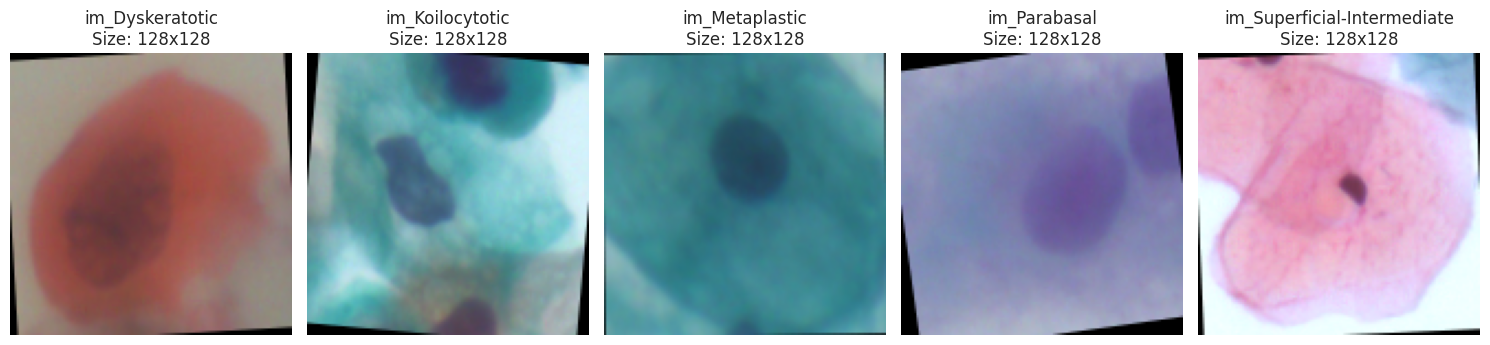

In [16]:
# Get class names
classes = sorted([cls for cls in os.listdir(output_dir) if os.path.isdir(os.path.join(output_dir, cls))])

# Create a figure for visualization
fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))

for i, cls in enumerate(classes):
    class_path = os.path.join(output_dir, cls)
    img_files = [f for f in os.listdir(class_path) if f.lower().endswith('.bmp')]

    # Select a random image
    img_file = random.choice(img_files)
    img_path = os.path.join(class_path, img_file)

    # Read image using OpenCV
    img = cv2.imread(img_path)
            
    # Get image dimensions
    height, width, _ = img.shape
    img_size = f"{width}x{height}"

    # Convert BGR to RGB for Matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image
    axes[i].imshow(img)
    axes[i].set_title(f"{cls}\nSize: {img_size}")  # Show class + size
    axes[i].axis("off")

plt.tight_layout()
plt.show()

# **Train Test Validate Split**

In [17]:
# Paths
train_dir = '/kaggle/working/sipakmed_augmented'
test_dir = '/kaggle/working/sipakmed_split/test'
batch_size = 32
epochs = 100

train_datagen = ImageDataGenerator(validation_split=0.2)
test_datagen = ImageDataGenerator()

Train_Generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (128, 128),
    batch_size = batch_size,
    shuffle =True,
    class_mode = 'sparse',
    subset = 'training'
)
Validation_Generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (128, 128),
    batch_size = batch_size,
    shuffle =True,
    class_mode = 'sparse',
    subset = 'validation'
)
Test_Generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (128, 128),
    batch_size = 500,
    class_mode = 'sparse',
)

Found 2841 images belonging to 5 classes.
Found 708 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


# **Model Development**

## CNN with offline augmentation

In [18]:
def create_model(input_shape, num_classes):

    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(64, (3, 3), activation="relu", kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])

    return model

In [19]:
input_shape = (128, 128, 3)  
num_classes = 5

cnn_model = create_model(input_shape, num_classes)

cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1744266383.024089      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744266383.024854      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [20]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,306,181 (12.61 MB)

 Trainable params: 3,305,733 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = cnn_model.fit(
    Train_Generator,
    validation_data=Validation_Generator,
    epochs=100,  
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744266397.114538     130 service.cc:148] XLA service 0x7921c0008770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744266397.115446     130 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744266397.115474     130 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744266397.555618     130 cuda_dnn.cc:529] Loaded cuDNN version 90300


 6/89 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3636 - loss: 2.5866

I0000 00:00:1744266401.878448     130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


89/89 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.6066 - loss: 1.5042 - val_accuracy: 0.5904 - val_loss: 1.4491
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7937 - loss: 0.6863 - val_accuracy: 0.6794 - val_loss: 1.0601
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8219 - loss: 0.5705 - val_accuracy: 0.6864 - val_loss: 1.3293
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8510 - loss: 0.4434 - val_accuracy: 0.6992 - val_loss: 1.2486
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8686 - loss: 0.4044 - val_accuracy: 0.7147 - val_loss: 1.2548
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8702 - loss: 0.3940 - val_accuracy: 0.7246 - val_loss: 1.2190
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8950 - loss: 0.3344 - val_accuracy: 0.7020 - val_loss: 1.5632
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8998 - loss: 0.3126 - val_accuracy: 0.7218 - val_

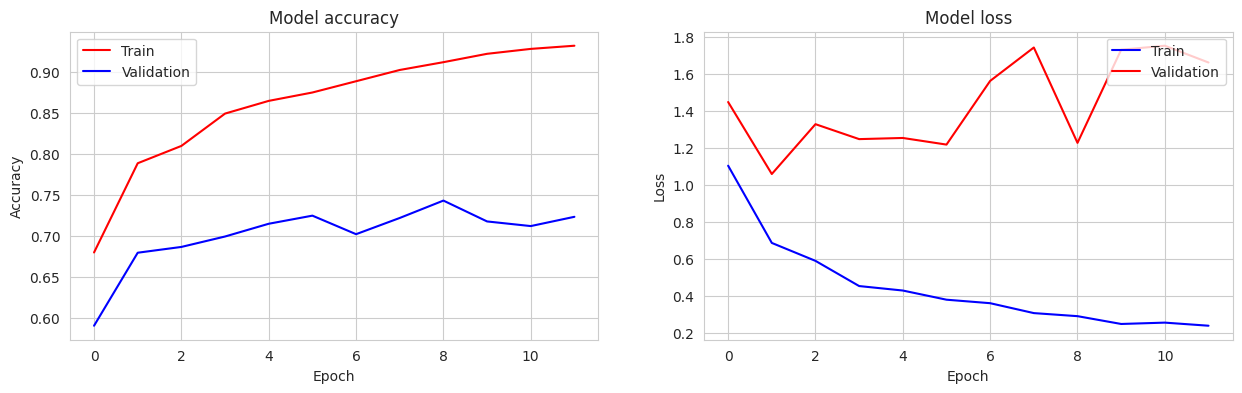

In [22]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],color='r')
plt.plot(history.history['val_accuracy'],color='b')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'],color='b')
plt.plot(history.history['val_loss'],color='r')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='upper right')

In [23]:
test_labels = Test_Generator.classes  
predictions = cnn_model.predict(Test_Generator)  
predicted_classes = np.argmax(predictions, axis=1)

from sklearn.metrics import classification_report

report = classification_report(test_labels, predicted_classes, target_names=list(Test_Generator.class_indices.keys()))
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.12      0.13      0.12       100
            im_Koilocytotic       0.12      0.08      0.10       100
             im_Metaplastic       0.19      0.23      0.21       100
               im_Parabasal       0.21      0.26      0.24       100
im_Superficial-Intermediate       0.14      0.12      0.13       100

                   accuracy                           0.16       500
                  macro avg       0.16      0.16      0.16       500
               weighted avg       0.16      0.16      0.16       500



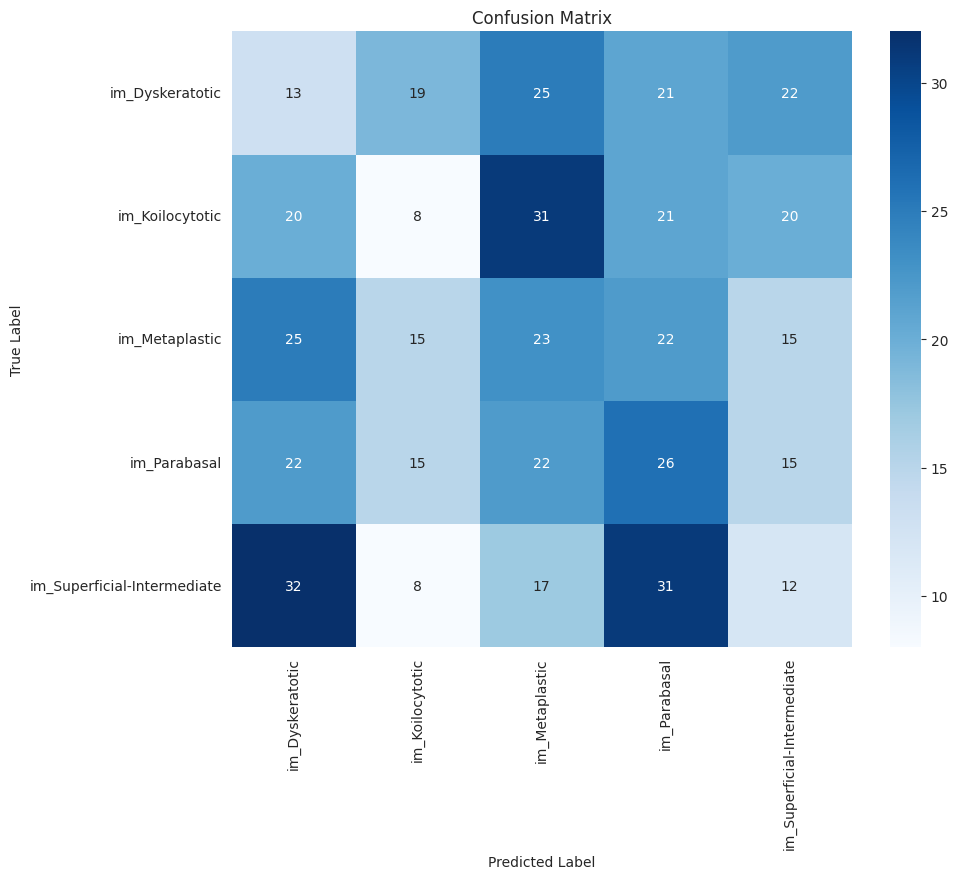

In [24]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(Test_Generator.class_indices.keys()), yticklabels=list(Test_Generator.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [25]:
# Paths
dataset_dir = '/kaggle/working/sipakmed_split/train'
batch_size = 32
epochs = 100
num_folds = 5

# Load dataset (image paths & labels)
image_paths = []
labels = []
class_names = sorted(os.listdir(dataset_dir))

for class_index, class_name in enumerate(class_names):
    class_path = os.path.join(dataset_dir, class_name)
    for img_file in os.listdir(class_path):
        if img_file.lower().endswith('.bmp'):
            image_paths.append(os.path.join(class_path, img_file))
            labels.append(class_index)  # Assign label based on class index

# Convert to NumPy arrays
image_paths = np.array(image_paths)
labels = np.array(labels)

# Define K-Fold Cross Validation
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
fold_no = 1
accuracy_per_fold = []
auc_per_fold = []
recall_per_fold = []
precision_per_fold = []

# Function to evaluate metrics
def evaluate_metrics(model, image_paths, labels):
    """ Compute AUC, Accuracy, Recall, and Precision """
    images = []
    
    for path in image_paths:
        img = cv2.imread(path)  # Load image (Already 128x128)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        images.append(img / 255.0)  # Normalize

    images = np.array(images)
    
    # Predict
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Compute Metrics
    accuracy = accuracy_score(labels, predicted_labels)
    recall = recall_score(labels, predicted_labels, average="macro")
    precision = precision_score(labels, predicted_labels, average="macro")

    # Compute ROC AUC Score
    labels_one_hot = to_categorical(labels, num_classes=len(class_names))
    auc = roc_auc_score(labels_one_hot, predictions, average="macro", multi_class="ovr")

    return accuracy, auc, recall, precision

# Loop through each fold
for train_idx, val_idx in kfold.split(image_paths, labels):
    print(f"\n🔹 Fold {fold_no}/{num_folds}")

    # Split data
    train_paths, val_paths = image_paths[train_idx], image_paths[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    def data_generator(image_paths, labels, batch_size):
        """ Custom generator to load images dynamically """
        while True:
            indices = np.arange(len(image_paths))
            np.random.shuffle(indices)  # Shuffle data each epoch
            for i in range(0, len(image_paths), batch_size):
                batch_indices = indices[i:i + batch_size]
                batch_paths = image_paths[batch_indices]
                batch_labels = labels[batch_indices]

                batch_images = []
                for path in batch_paths:
                    img = cv2.imread(path)  # Load image (Already 128x128)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                    batch_images.append(img)

                batch_images = np.array(batch_images) / 255.0  # Normalize
                yield batch_images, np.array(batch_labels)

    # Create train & validation generators
    train_generator = data_generator(train_paths, train_labels, batch_size)
    val_generator = data_generator(val_paths, val_labels, batch_size)

    # Build CNN Model
    input_shape = (128, 128, 3)  
    num_classes = len(class_names)

    model = create_model(input_shape, num_classes)

    # Compile model
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    # Save best model
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        "/kaggle/working/best_model1.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode="max"
    )

    # Train model
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_paths) // batch_size + (len(train_paths) % batch_size != 0),
        validation_data=val_generator,
        validation_steps=len(val_paths) // batch_size + (len(val_paths) % batch_size != 0),
        epochs=epochs,
        verbose=1,
        callbacks=[checkpoint_callback]
    )

    # Evaluate model
    loss, accuracy = model.evaluate(val_generator, steps=len(val_paths) // batch_size + (len(val_paths) % batch_size != 0))
    print(f"Fold {fold_no} Accuracy: {accuracy:.4f}")
    
    # Compute additional metrics
    accuracy, auc, recall, precision = evaluate_metrics(model, val_paths, val_labels)
    print(f"Fold {fold_no} Metrics → Accuracy: {accuracy:.4f}, AUC: {auc:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}")

    # Store results
    accuracy_per_fold.append(accuracy)
    auc_per_fold.append(auc)
    recall_per_fold.append(recall)
    precision_per_fold.append(precision)

    fold_no += 1

# Print final results
print("\n🔹 Final Cross-Validation Results 🔹")
for i in range(num_folds):
    print(f"Fold {i+1} → Accuracy: {accuracy_per_fold[i]:.4f}, AUC: {auc_per_fold[i]:.4f}, Recall: {recall_per_fold[i]:.4f}, Precision: {precision_per_fold[i]:.4f}")

print(f"\n Average Metrics: ")
print(f"  Accuracy: {np.mean(accuracy_per_fold):.4f}")
print(f"  AUC Score: {np.mean(auc_per_fold):.4f}")
print(f"  Recall: {np.mean(recall_per_fold):.4f}")
print(f"  Precision: {np.mean(precision_per_fold):.4f}")


🔹 Fold 1/5
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.5545 - loss: 6.2867 - val_accuracy: 0.1930 - val_loss: 20.5948
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6659 - loss: 2.3507 - val_accuracy: 0.2000 - val_loss: 15.3492
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7181 - loss: 1.3534 - val_accuracy: 0.1958 - val_loss: 29.0776
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7407 - loss: 1.1264 - val_accuracy: 0.2042 - val_loss: 14.5168
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7612 - loss: 0.8901 - val_accuracy: 0.2789 - val_loss: 13.6548
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7844 - loss: 0.7711 - val_accuracy: 0.5338 - val_loss: 2.5633
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7875 - loss: 0.6765 - val_accuracy: 0.8254 - val_loss: 0.5880
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8007 - loss: 0.7446 - val_accuracy: 0.6127 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.5668 - loss: 6.3252 - val_accuracy: 0.1958 - val_loss: 28.2802
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7003 - loss: 2.8866 - val_accuracy: 0.1958 - val_loss: 19.6876
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7211 - loss: 1.5277 - val_accuracy: 0.1944 - val_loss: 32.4932
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7647 - loss: 0.9341 - val_accuracy: 0.2380 - val_loss: 17.7525
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7869 - loss: 0.8699 - val_accuracy: 0.4944 - val_loss: 5.3573
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7951 - loss: 0.7927 - val_accuracy: 0.5746 - val_loss: 1.9552
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8097 - loss: 0.6211 - val_accuracy: 0.7239 - val_loss: 1.2524
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8042 - loss: 0.6210 - val_accuracy: 0.7324 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.5752 - loss: 5.4355 - val_accuracy: 0.1944 - val_loss: 41.3065
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7083 - loss: 1.9950 - val_accuracy: 0.1944 - val_loss: 54.1898
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7194 - loss: 1.1749 - val_accuracy: 0.2169 - val_loss: 27.8347
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7628 - loss: 0.9882 - val_accuracy: 0.2676 - val_loss: 16.6581
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7631 - loss: 0.8345 - val_accuracy: 0.6225 - val_loss: 4.2646
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8068 - loss: 0.6187 - val_accuracy: 0.7592 - val_loss: 2.1640
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8040 - loss: 0.7009 - val_accuracy: 0.8099 - val_loss: 0.5958
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8241 - loss: 0.5838 - val_accuracy: 0.5493 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.5681 - loss: 6.0343 - val_accuracy: 0.1930 - val_loss: 25.9524
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6871 - loss: 2.5070 - val_accuracy: 0.1972 - val_loss: 19.8343
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7500 - loss: 1.0658 - val_accuracy: 0.1930 - val_loss: 28.0633
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7792 - loss: 0.8254 - val_accuracy: 0.2352 - val_loss: 14.7956
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7734 - loss: 0.8076 - val_accuracy: 0.4958 - val_loss: 4.5322
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7792 - loss: 0.7042 - val_accuracy: 0.7451 - val_loss: 1.7666
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7985 - loss: 0.6312 - val_accuracy: 0.8127 - val_loss: 0.7412
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8158 - loss: 0.6027 - val_accuracy: 0.8380 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.5646 - loss: 5.3537 - val_accuracy: 0.1932 - val_loss: 21.8655
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6871 - loss: 2.7961 - val_accuracy: 0.1932 - val_loss: 30.4434
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7336 - loss: 1.4590 - val_accuracy: 0.1932 - val_loss: 30.3735
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7387 - loss: 1.0781 - val_accuracy: 0.2102 - val_loss: 30.1966
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7511 - loss: 0.8953 - val_accuracy: 0.5303 - val_loss: 6.2307
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7853 - loss: 0.6724 - val_accuracy: 0.6643 - val_loss: 2.2051
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8076 - loss: 0.6715 - val_accuracy: 0.5614 - val_loss: 1.9869
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7548 - loss: 0.7786 - val_accuracy: 0.7842 - 

## **ResNet**

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam  # Import Adam optimizer

def create_resnet_model(input_shape, num_classes):
    base_model = ResNet50(weights=None, include_top=False, input_shape=input_shape)
    
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

input_shape = (128, 128, 3)  
num_classes = 5

resnet_model = create_resnet_model(input_shape, num_classes)
resnet_model.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Optionally, print model summary to verify your architecture
resnet_model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,629 (90.98 MB)

 Trainable params: 23,797,509 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [27]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = resnet_model.fit(
    Train_Generator,
    validation_data=Validation_Generator,
    epochs=100,  
    #callbacks=[early_stopping],
    verbose=1
)

 
   

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 108s 448ms/step - accuracy: 0.3599 - loss: 2.0232 - val_accuracy: 0.1935 - val_loss: 1.9186
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.6985 - loss: 1.0661 - val_accuracy: 0.2458 - val_loss: 2.0957
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.7136 - loss: 0.9812 - val_accuracy: 0.3107 - val_loss: 1.9227
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.7672 - loss: 0.8515 - val_accuracy: 0.6822 - val_loss: 1.3440
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.7521 - loss: 0.8726 - val_accuracy: 0.6342 - val_loss: 1.3891
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.8000 - loss: 0.7759 - val_accuracy: 0.4958 - val_loss: 2.4150
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.7916 - loss: 0.7931 - val_accuracy: 0.6144 - val_loss: 1.4421
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.8284 - loss: 0.7000 -

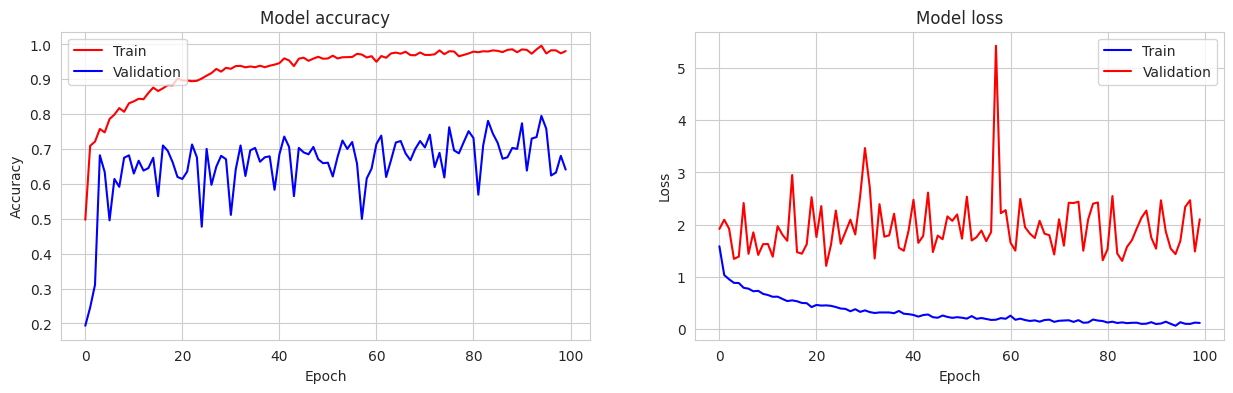

In [28]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],color='r')
plt.plot(history.history['val_accuracy'],color='b')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'],color='b')
plt.plot(history.history['val_loss'],color='r')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='upper right')

### **Kfold**

In [29]:
# Paths
dataset_dir = '/kaggle/working/sipakmed_split/train'
batch_size = 32
epochs = 100
num_folds = 5

# Load dataset (image paths & labels)
image_paths = []
labels = []
class_names = sorted(os.listdir(dataset_dir))

for class_index, class_name in enumerate(class_names):
    class_path = os.path.join(dataset_dir, class_name)
    for img_file in os.listdir(class_path):
        if img_file.lower().endswith('.bmp'):
            image_paths.append(os.path.join(class_path, img_file))
            labels.append(class_index)  # Assign label based on class index

# Convert to NumPy arrays
image_paths = np.array(image_paths)
labels = np.array(labels)

# Define K-Fold Cross Validation
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
fold_no = 1
accuracy_per_fold = []
auc_per_fold = []
recall_per_fold = []
precision_per_fold = []

# Function to evaluate metrics
def evaluate_metrics(model, image_paths, labels):
    """ Compute AUC, Accuracy, Recall, and Precision """
    images = []
    
    for path in image_paths:
        img = cv2.imread(path)  # Load image (Already 128x128)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        images.append(img / 255.0)  # Normalize

    images = np.array(images)
    
    # Predict
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Compute Metrics
    accuracy = accuracy_score(labels, predicted_labels)
    recall = recall_score(labels, predicted_labels, average="macro")
    precision = precision_score(labels, predicted_labels, average="macro")

    # Compute ROC AUC Score
    labels_one_hot = to_categorical(labels, num_classes=len(class_names))
    auc = roc_auc_score(labels_one_hot, predictions, average="macro", multi_class="ovr")

    return accuracy, auc, recall, precision

# Loop through each fold
for train_idx, val_idx in kfold.split(image_paths, labels):
    print(f"\n🔹 Fold {fold_no}/{num_folds}")

    # Split data
    train_paths, val_paths = image_paths[train_idx], image_paths[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    def data_generator(image_paths, labels, batch_size):
        """ Custom generator to load images dynamically """
        while True:
            indices = np.arange(len(image_paths))
            np.random.shuffle(indices)  # Shuffle data each epoch
            for i in range(0, len(image_paths), batch_size):
                batch_indices = indices[i:i + batch_size]
                batch_paths = image_paths[batch_indices]
                batch_labels = labels[batch_indices]

                batch_images = []
                for path in batch_paths:
                    img = cv2.imread(path)  # Load image (Already 128x128)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                    batch_images.append(img)

                batch_images = np.array(batch_images) / 255.0  # Normalize
                yield batch_images, np.array(batch_labels)

    # Create train & validation generators
    train_generator = data_generator(train_paths, train_labels, batch_size)
    val_generator = data_generator(val_paths, val_labels, batch_size)

    # Build CNN Model
    input_shape = (128, 128, 3)  
    num_classes = len(class_names)

    model = create_resnet_model(input_shape, num_classes)

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='sparse_categorical_crossentropy', 
                     metrics=['accuracy'])

    # Save best model
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        "/kaggle/working/best_model2.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode="max"
    )

    # Train model
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_paths) // batch_size + (len(train_paths) % batch_size != 0),
        validation_data=val_generator,
        validation_steps=len(val_paths) // batch_size + (len(val_paths) % batch_size != 0),
        epochs=epochs,
        verbose=1,
        callbacks=[checkpoint_callback]
    )

    # Evaluate model
    loss, accuracy = model.evaluate(val_generator, steps=len(val_paths) // batch_size + (len(val_paths) % batch_size != 0))
    print(f"✅ Fold {fold_no} Accuracy: {accuracy:.4f}")
    
    # Compute additional metrics
    accuracy, auc, recall, precision = evaluate_metrics(model, val_paths, val_labels)
    print(f"📌 Fold {fold_no} Metrics → Accuracy: {accuracy:.4f}, AUC: {auc:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}")

    # Store results
    accuracy_per_fold.append(accuracy)
    auc_per_fold.append(auc)
    recall_per_fold.append(recall)
    precision_per_fold.append(precision)

    fold_no += 1

# Print final results
print("\n🔹 Final Cross-Validation Results 🔹")
for i in range(num_folds):
    print(f"Fold {i+1} → Accuracy: {accuracy_per_fold[i]:.4f}, AUC: {auc_per_fold[i]:.4f}, Recall: {recall_per_fold[i]:.4f}, Precision: {precision_per_fold[i]:.4f}")

print(f"\n📌 Average Metrics: ")
print(f"  🔹 Accuracy: {np.mean(accuracy_per_fold):.4f}")
print(f"  🔹 AUC Score: {np.mean(auc_per_fold):.4f}")
print(f"  🔹 Recall: {np.mean(recall_per_fold):.4f}")
print(f"  🔹 Precision: {np.mean(precision_per_fold):.4f}")


🔹 Fold 1/5
Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 105s 459ms/step - accuracy: 0.3741 - loss: 1.9661 - val_accuracy: 0.1930 - val_loss: 2.7014
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.6576 - loss: 1.1253 - val_accuracy: 0.1930 - val_loss: 5.9489
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 0.7334 - loss: 0.9693 - val_accuracy: 0.1930 - val_loss: 14.8247
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 0.7375 - loss: 0.9541 - val_accuracy: 0.2000 - val_loss: 8.4700
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.7616 - loss: 0.8576 - val_accuracy: 0.3648 - val_loss: 4.4749
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 0.8026 - loss: 0.7610 - val_accuracy: 0.4817 - val_loss: 3.1704
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 0.8058 - loss: 0.7510 - val_accuracy: 0.6366 - val_loss: 1.5880
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 0.8123 - l

In [30]:
test_labels = Test_Generator.classes  
predictions = cnn_model.predict(Test_Generator)  
predicted_classes = np.argmax(predictions, axis=1)

from sklearn.metrics import classification_report

report = classification_report(test_labels, predicted_classes, target_names=list(Test_Generator.class_indices.keys()))
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.21      0.24      0.23       100
            im_Koilocytotic       0.20      0.13      0.16       100
             im_Metaplastic       0.17      0.20      0.18       100
               im_Parabasal       0.20      0.24      0.22       100
im_Superficial-Intermediate       0.11      0.09      0.10       100

                   accuracy                           0.18       500
                  macro avg       0.18      0.18      0.18       500
               weighted avg       0.18      0.18      0.18       500



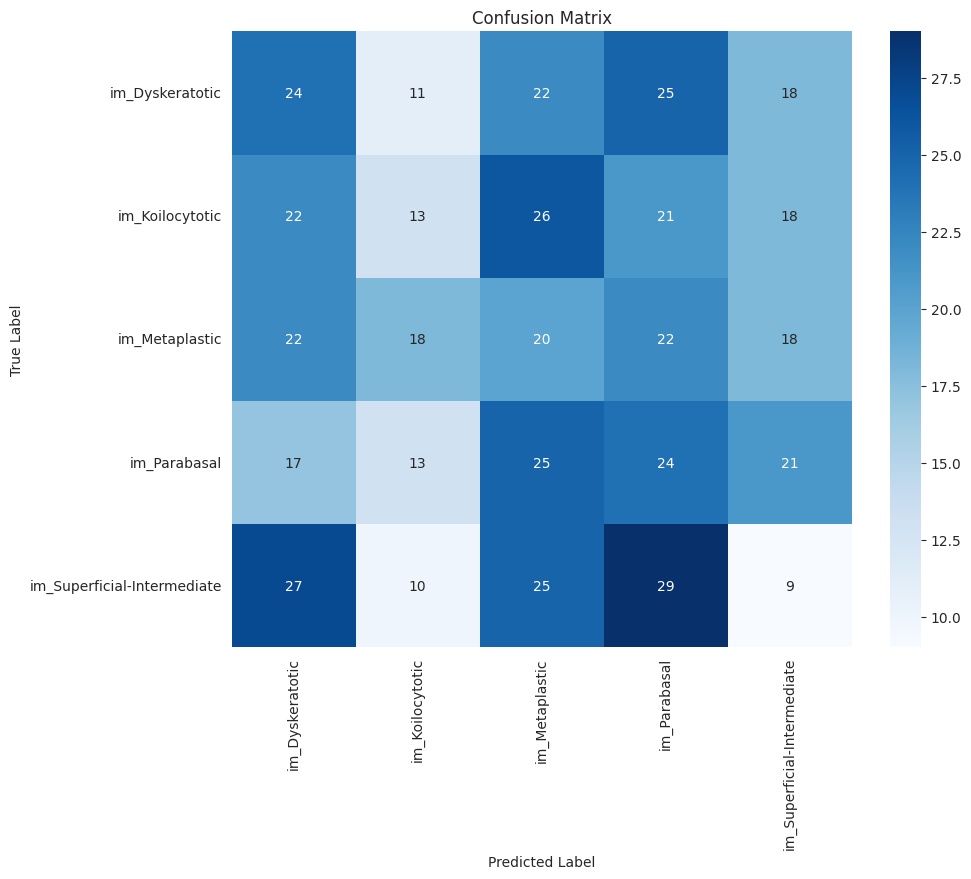

In [31]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(Test_Generator.class_indices.keys()), yticklabels=list(Test_Generator.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [32]:
!pip install lime

## **LIME**

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries

def explain_with_lime(model, image, class_names):
    
    # Define the explainer
    explainer = lime_image.LimeImageExplainer()

    # Define a prediction function
    def predict_fn(images):
        images = np.array(images)
        preds = model.predict(images)
        return preds

    # Explain the image
    explanation = explainer.explain_instance(
        image, 
        predict_fn, 
        top_labels=5, 
        hide_color=0, 
        num_samples=1000
    )

    # Visualize explanation for the top predicted class
    top_predicted_class = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(
        top_predicted_class, 
        positive_only=True, 
        num_features=5, 
        hide_rest=False
    )

    # Show the explanation
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f"LIME Explanation - {class_names[top_predicted_class]}")
    
    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

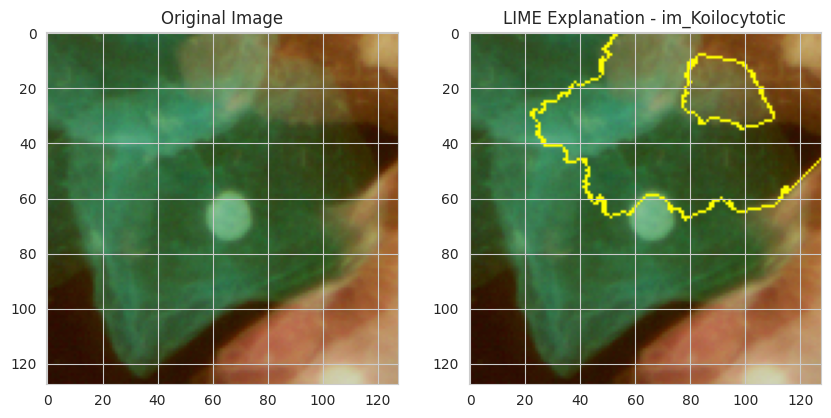

In [35]:
# Select an image from test data
test_images, test_labels = next(Test_Generator)
test_image = test_images[0]  # Select the first image
test_image = (test_image * 255).astype(np.uint8)
true_label = test_labels[0]

class_names = list(Test_Generator.class_indices.keys())

# Explain the prediction
explain_with_lime(cnn_model, test_image, class_names)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━

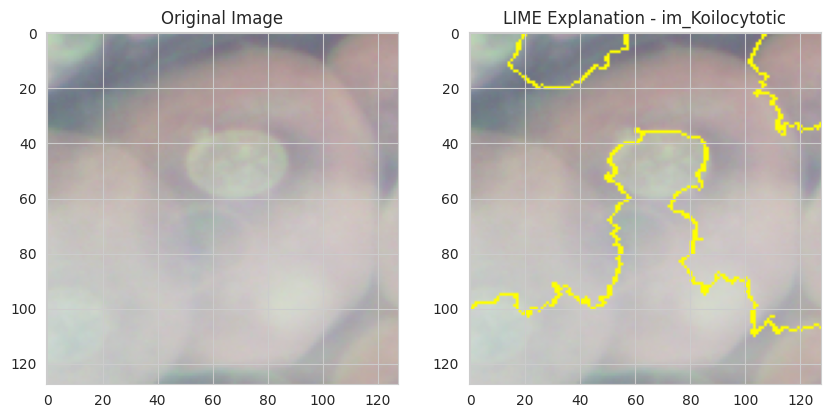

In [36]:
# Select an image from test data
test_images, test_labels = next(Test_Generator)
test_image = test_images[0]  # Select the first image
test_image = (test_image * 255).astype(np.uint8)
true_label = test_labels[0]


# Explain the prediction
explain_with_lime(resnet_model, test_image, class_names)